In [1]:
import tensorflow as tf
import keras
import keras.backend as K
print (tf.__version__, keras.__version__)

import os
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

import numpy as np
import random

import seaborn as sns
from random import randint
import pandas as pd

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from PIL import Image
from glob import glob
from tqdm import tqdm, tqdm_notebook

%pylab inline
%matplotlib inline

sys.path.append('script/')
from metrics import *
from ressources import *
from model import *
from weights_path import *
sys.path.append('/root/Keras-ResNeXt/')
from resnext import ResNext

Using TensorFlow backend.


1.12.0 2.2.4
Populating the interactive namespace from numpy and matplotlib


/root/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'minimum', 'randint', 'add', 'multiply', 'maximum', 'copy', 'dot', 'average', 'subtract', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
name = ''
height, width, channel = 224, 224, 3
batch_size = 32
trainDir = 'TrainingSetImagesDir/'
testDir = 'TestSetImagesDir/'

In [3]:
df_train = pd.read_csv('TrainingSet_20aimVO.csv')
df_test = pd.read_csv('Mauna_Kea_Supp_Material/test_data_order.csv')

In [4]:
# drop_lbl = list(df_train.loc[df_train['class_number'] == 3].index.values)
# drop_lbl = drop_lbl[:len(drop_lbl)//2]
# df_train = df_train.drop(drop_lbl)

# drop_lbl = list(df_train.loc[df_train['class_number'] == 1].index.values)
# drop_lbl = drop_lbl[:len(drop_lbl)//2]
# df_train = df_train.drop(drop_lbl)

# list(df_train.loc[df_train['class_number'] == 1].sample(10).image_filename.values)

In [5]:
classes = ['Squamous_Epithelium', 'Intestinal_metaplasia', 'Gastric_metaplasia', 'Dysplasia_and_Cancer']
labeled_files = glob('TrainingSetImagesDir/*.png')
labeled_files = [lbl for lbl in labeled_files if  lbl.split(os.path.sep)[-1] in list(df_train.image_filename.values)]
id_label_map = {k:v for k, v in zip(df_train.image_filename.values, df_train.class_number.values)}

/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


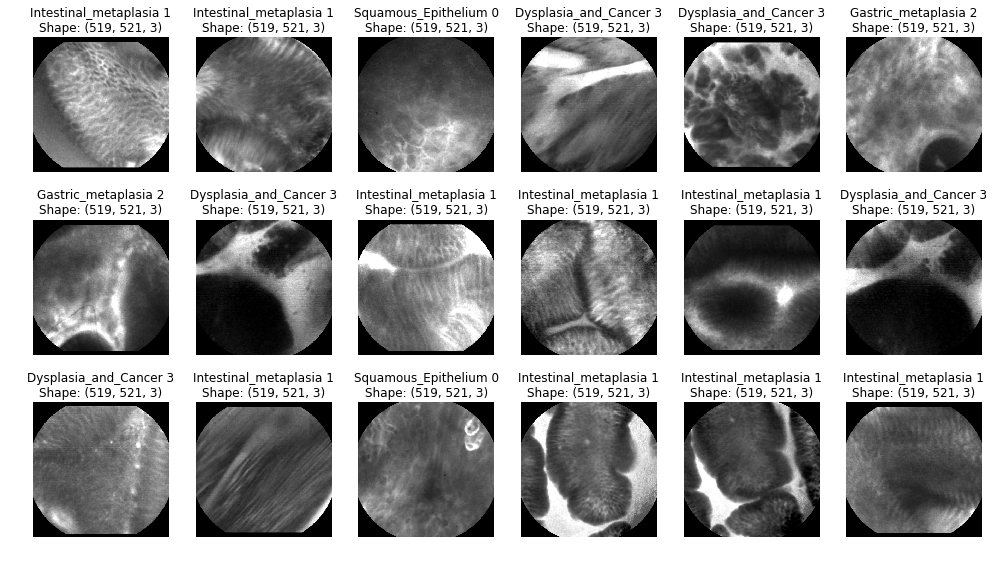

In [6]:
cols = 6
rows = 4

randomLst = []
for i in range(0, (rows * cols)):
    randomLst.append(randint(0, len(labeled_files)))

plot_imgs(randomLst, classes, labeled_files, id_label_map, cols=6, rows=3)

In [7]:
imgNameLst = [['TrainingSetImagesDir/{}'.format(name)
           for name in list(df_train.loc[df_train['class_number'] == i].sample(6).image_filename.values)]
            for i in range(0, 4)]

In [8]:
rows = 4
cols = 4

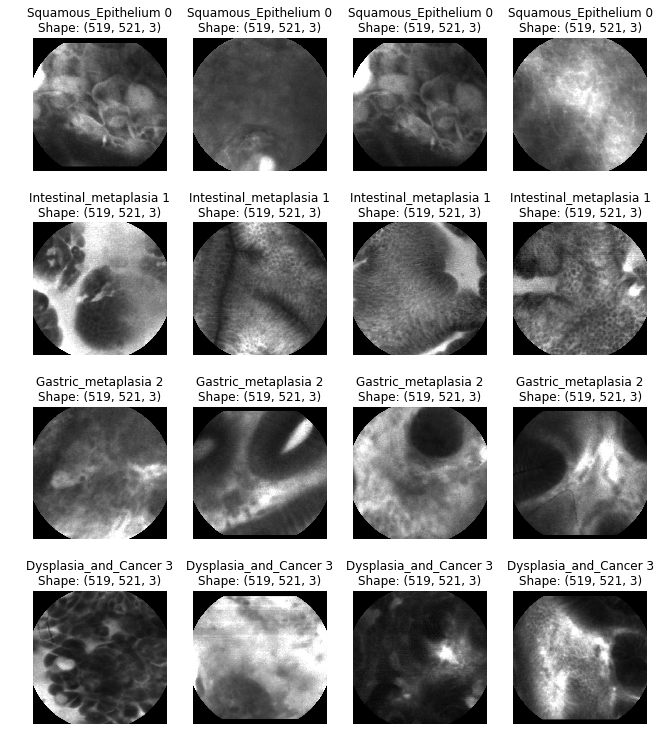

In [9]:
plot_imgs_by_id(imgNameLst, classes, labeled_files, id_label_map, rows, cols)

In [10]:
# df_train.image_filename.sample(1).values[0]

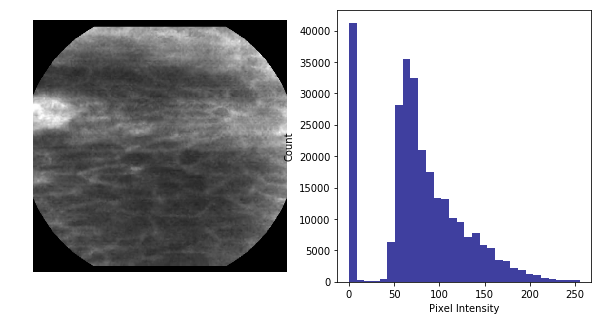

In [11]:
plotHistogram(cv.imread('TrainingSetImagesDir/{}'.format(df_train.image_filename.sample(1).values[0])))   

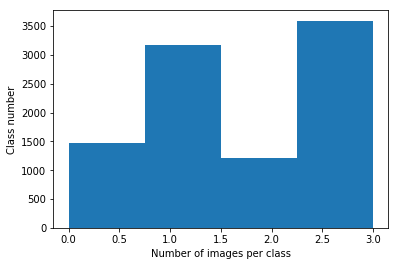

In [12]:
plt.hist(df_train['class_number'].values.astype(int), bins=4)
plt.xlabel('Number of images per class')
plt.ylabel('Class number')
plt.show()

{0: 'Squamous_Epithelium', 1: 'Intestinal_metaplasia', 2: 'Gastric_metaplasia', 3: 'Dysplasia_and_Cancer'}


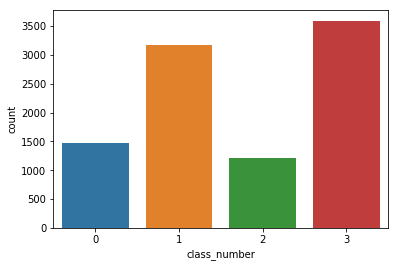

In [13]:
map_characters = {0: 'Squamous_Epithelium', 1: 'Intestinal_metaplasia', 2: 'Gastric_metaplasia', 3: 'Dysplasia_and_Cancer'}
df = pd.DataFrame()
dist = df_train['class_number'].value_counts()
sns.countplot(df_train['class_number'])
print(map_characters)

In [14]:
cw = class_weight.compute_class_weight('balanced', np.unique(df_train['class_number'].values), df_train['class_number'].values)
print (cw)

[1.60755616 0.7433113  1.95812604 0.65706733]


In [15]:
# print (inception_resnet_v2_path)

In [16]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.losses import binary_crossentropy, categorical_crossentropy

In [17]:
# [x for x in dir() if '_path' in x]

In [18]:
# base_model = NASNetMobile(include_top=False, input_shape=(224, 224, 3))#, weights=None

In [19]:
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201, DenseNet169, DenseNet121
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

In [20]:
gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

In [21]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [58]:
K.clear_session()

weights = mobilenet_path
pretrained_model = MobileNetV2(weights='imagenet', include_top=False)

model = get_model_1(pretrained_model, 4, 0)
# model = get_model_classif_nasnet(pretrained_model, 4, 0)

/root/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [59]:
name = 'retrain_mobilenet'
height, width, channel = 224, 224, 3
batch_size = 32
trainDir = 'TrainingSetImagesDir/'
testDir = 'TestSetImagesDir/'
print (name)

retrain_mobilenet


In [43]:
df_train['class_number'] = df_train['class_number'].astype('str')
train, val = train_test_split(df_train, test_size=0.05, random_state=42)

print (len(train), len(val))

8973 473


In [28]:
rand = np.random.randint(0, len(labeled_files))

In [29]:
datagen = datagen_create(True)

train_generator=datagen.flow_from_dataframe(directory=trainDir,
                                            dataframe=train,
                                            x_col="image_filename",
                                            y_col="class_number",
                                            class_mode="categorical",
                                            target_size=(height, width),
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=42)

datagen = datagen_create(True)

validation_generator = datagen.flow_from_dataframe(directory=trainDir,
                                            dataframe=val,
                                            x_col="image_filename",
                                            y_col="class_number",
                                            class_mode="categorical",
                                            target_size=(height, width),
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=42)

Found 8973 validated image filenames belonging to 4 classes.
Found 473 validated image filenames belonging to 4 classes.


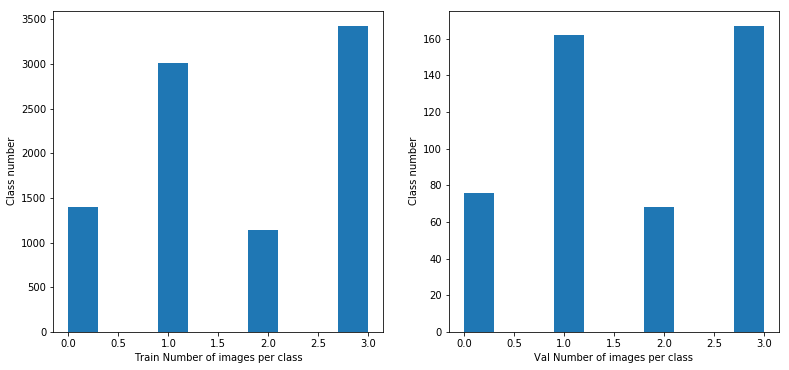

In [30]:
plot2histo(train_generator.classes,
           validation_generator.classes,
          'Train Number of images per class',
          'Class number',
          'Val Number of images per class',
          'Class number')

In [31]:
# df_train['class_number'].value_counts().plot(kind='bar')

In [32]:
tensorDir = './logs2/{}/'.format(name)
tensorboard = keras.callbacks.TensorBoard(log_dir=tensorDir, 
                                          histogram_freq=0, 
                                          batch_size=batch_size, 
                                          write_graph=True, 
                                          write_grads=True, 
                                          write_images=True, 
                                          embeddings_freq=0,
                                          embeddings_layer_names=None, 
                                          embeddings_metadata=None)

filepath = './model2/{}_{}'.format(name, 'weights.{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5')
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              factor=0.5,
                              patience=1,
                              verbose=1,
                              mode='max',
                              min_lr=0.00001)

earlyStp = EarlyStopping(monitor='val_loss',
                         min_delta=1e-5,
                         patience=7,
                         verbose=1,
                         mode='auto')

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

print (name)
print (class_weights)

retrain_densenet121
[1.6103733  0.74402985 1.97122144 0.65458127]


In [327]:
model.save('model2/final_' + name + '.hdf5')
print ('model2/final_' + name + '.hdf5 saved')
# model.load_weights('./model2/retrain_densenet169_weights.30-0.01-1.00-0.03-0.99.hdf5')

model2/final_retrain_xception.hdf5 saved


In [330]:
datagen = ImageDataGenerator(rescale=1./255)
validation_generator = datagen.flow_from_dataframe(directory=trainDir,
                                            dataframe=df_train,
                                            x_col="image_filename",
                                            y_col="class_number",
                                            class_mode='categorical',
                                            target_size=(height, width),
                                            batch_size=1,
                                            shuffle=False,
                                            pickle_safe = True,
                                            workers = batch_size,
                                            seed=42)

Found 9446 validated image filenames belonging to 4 classes.


In [331]:
val_predictions = model.predict_generator(validation_generator,
                                          steps=(len(validation_generator.filenames)),
                                          verbose=1)

9446/9446 [==============================] - 101s 11ms/step


<h1>Test Time Augmentation (TTA)</h1>

In [332]:
# tta_steps = 20
# predictions = []
# bs = 32
# for i in range(tta_steps):
#     preds = model.predict_generator(validation_generator, steps=(len(validation_generator.filenames)//batch_size) + 1, verbose=1)
#     predictions.append(preds)

In [333]:
#  predictions = model.predict_generator(validation_generator, steps=(len(validation_generator.filenames)), verbose=1)

In [334]:
# val_predictions = np.mean(predictions, axis=0)

In [335]:
# print (val_predictions)

In [336]:
# preds = model.predict_generator(validation_generator, steps=(len(validation_generator.filenames)//batch_size) + 1, verbose=1)

In [337]:
# print (validation_generator.filenames)

<h1>Validation Prediction</h1>

In [338]:
y_pred_val_classes = np.argmax(val_predictions, axis=1)

y_pred_val_max_probas = np.max(val_predictions, axis=1)

In [339]:
len(val_predictions)

9446

In [340]:
confusion_matrix(validation_generator.classes, y_pred_val_classes)

array([[1466,    2,    1,    0],
       [   0, 3173,    0,    4],
       [   4,    8, 1187,    7],
       [   6,    5,    8, 3575]])

In [341]:
classes = ['0', '1', '2', '3']

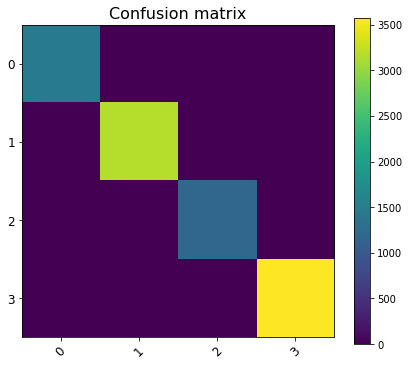

accuracy: 0.9952360787634977


In [342]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
def plot_confusion_matrix(y, y_pred):
    plt.figure(figsize=(7, 6))
    plt.title('Confusion matrix', fontsize=16)
    plt.imshow(confusion_matrix(y, y_pred))
    plt.xticks(np.arange(4), classes, rotation=45, fontsize=12)
    plt.yticks(np.arange(4), classes, fontsize=12)
    plt.colorbar()
    plt.show()
    print("accuracy:", accuracy_score(y, y_pred))
plot_confusion_matrix(validation_generator.classes, y_pred_val_classes)

In [343]:
print(classification_report(validation_generator.classes, y_pred_val_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1469
           1       1.00      1.00      1.00      3177
           2       0.99      0.98      0.99      1206
           3       1.00      0.99      1.00      3594

    accuracy                           1.00      9446
   macro avg       0.99      0.99      0.99      9446
weighted avg       1.00      1.00      1.00      9446



<h1>Test Prediciton</h1>

In [61]:
testImgs = glob('TestSetImagesDir/*/*.png')

df_sub = pd.DataFrame({'image_filename':df_test.image_filename.values, "class_number":['0'] * len(df_test.image_filename.values)})

sub_generator = datagen.flow_from_dataframe(directory='test/',
                                            dataframe=df_sub,
                                            x_col="image_filename",
                                            y_col="class_number",
                                            class_mode='categorical',
                                            target_size=(height, width),
                                            batch_size=1,
                                            shuffle=False,
                                             pickle_safe = True,
                                             workers = 1,
                                            seed=42)

num_test_images = len(testImgs)

# make sure we are using the best epoch

sub_predictions = model.predict_generator(sub_generator, steps=num_test_images, verbose=1)

np.save('{}.npy'.format(name), sub_predictions)
print ('preds save at {}.npy'.format(name))

Found 1715 validated image filenames belonging to 1 classes.
1715/1715 [==============================] - 21s 12ms/step
preds save at retrain_mobilenet.npy


In [346]:
df_psd = pd.read_csv('pseudo_label.csv')

In [347]:
# df_psd = df_psd.drop('Unnamed: 0', 1)

<p>Prediction on pseudo labelling</p>

In [348]:
df_psd['class_number'] = df_psd.class_number.values.astype('str')

In [349]:
list(df_psd)

['Unnamed: 0', 'image_filename', 'class_number']

In [350]:
testDir

'TestSetImagesDir/'

In [351]:
df_psd.head()

,Unnamed: 0,image_filename,class_number
0,0,im_33_37.png,1
1,1,im_108_26.png,3
2,2,im_10_16.png,0
3,3,im_66_57.png,0
4,4,im_87_20.png,3


In [352]:
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_dataframe(directory='test',
                                            dataframe=df_psd,
                                            x_col="image_filename",
                                            y_col="class_number",
                                            class_mode='categorical',
                                            target_size=(height, width),
                                            batch_size=1,
                                            shuffle=False,
                                            pickle_safe = True,
                                            workers = 1,
                                            seed=42)

Found 373 validated image filenames belonging to 4 classes.


In [353]:
test_predictions = model.predict_generator(test_generator,
                                          steps=(len(test_generator.filenames)),
                                          verbose=1)

373/373 [==============================] - 4s 11ms/step


In [354]:
y_pred_val_classes = np.argmax(test_predictions, axis=1)
y_pred_val_max_probas = np.max(test_predictions, axis=1)

In [355]:
confusion_matrix(test_generator.classes, y_pred_val_classes)

array([[ 62,   0,   0,   0],
       [  0,  90,   0,   0],
       [  0,   0,  46,   0],
       [  1,   3,   0, 171]])

In [356]:
classes = ['0', '1', '2', '3']

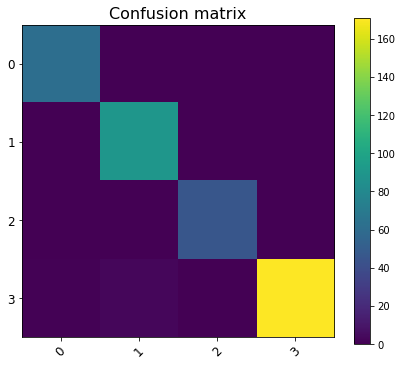

accuracy: 0.9892761394101877


In [357]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
def plot_confusion_matrix(y, y_pred):
    plt.figure(figsize=(7, 6))
    plt.title('Confusion matrix', fontsize=16)
    plt.imshow(confusion_matrix(y, y_pred))
    plt.xticks(np.arange(4), classes, rotation=45, fontsize=12)
    plt.yticks(np.arange(4), classes, fontsize=12)
    plt.colorbar()
    plt.show()
    print("accuracy:", accuracy_score(y, y_pred))
plot_confusion_matrix(test_generator.classes, y_pred_val_classes)

In [94]:
# plot_pred_imgs(val_predictions, classes, labeled_files, id_label_map, cols=8, rows=3)

<h1>Plot prediction</h1>

In [64]:
# cols = 5
# rows = 2
# ind = 0
# #pour allouer un cadre
# randomLst = []
# for i in range(0, (cols * rows)):
#     randomLst.append(np.random.randint(0, len(validation_generator.filenames)))
# fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
# for i in range(cols):
#     for j in range(rows):
#         random_index = randomLst[ind]
#         ax = fig.add_subplot(rows, cols, i * rows + j + 1)
#         ax.grid('off')
#         ax.axis('off')
#         imgName = validation_generator.filepaths[random_index]
#         img = cv.imread(imgName)
# #         print (np.argmax(model.predict(read_and_resize(img))[0]))
#         ax.imshow(img)
        
#         ax.set_title("Label: {}\nShape: {}\nPrediction: {}".format(id_label_map[imgName.split(os.path.sep)[-1]],
#                                                                    img.shape,
#                                                                    np.argmax(val_predictions[random_index])))
#         ind += 1
# plt.show()

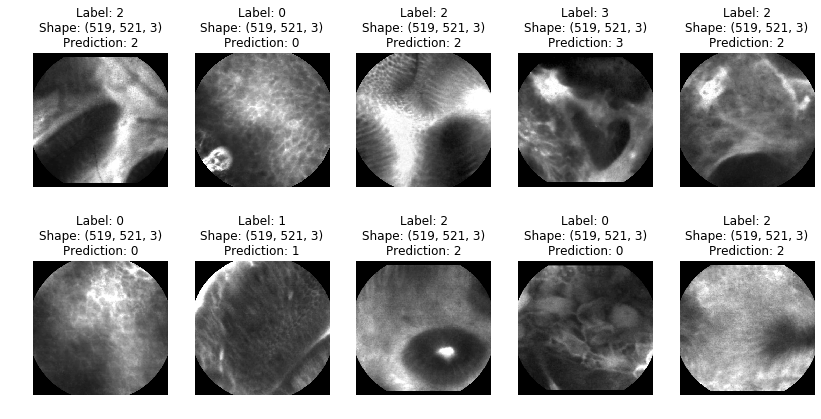

In [151]:
cols = 5
rows = 2
ind = 0
#pour allouer un cadre
randomLst = []
for i in range(0, (cols * rows)):
    randomLst.append(np.random.randint(0, len(test_generator.filenames)))
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = randomLst[ind]
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        imgName = test_generator.filepaths[random_index]
        img = cv.imread(imgName)
#         print (np.argmax(model.predict(read_and_resize(img))[0]))
        ax.imshow(img)
    
        
        ax.set_title("Label: {}\nShape: {}\nPrediction: {}".format(id_label_map[imgName.split(os.path.sep)[-1]],
                                                                   img.shape,
                                                                   np.argmax(test_predictions[random_index])))
        ind += 1
plt.show()

In [207]:
# plot_pred_imgs(sub_generator, classes, labeled_files, id_label_map)

In [208]:
# cols = 5
# rows = 2
# ind = 0
# #pour allouer un cadre
# randomLst = []
# for i in range(0, (cols * rows)):
#     randomLst.append(np.random.randint(0, len(sub_generator.filenames)))
# fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
# for i in range(cols):
#     for j in range(rows):
#         random_index = randomLst[ind]
#         ax = fig.add_subplot(rows, cols, i * rows + j + 1)
#         ax.grid('off')
#         ax.axis('off')
#         imgName = sub_generator.filepaths[random_index]
#         img = cv.imread(imgName)
# #         print (np.argmax(model.predict(read_and_resize(img))[0]))
#         ax.imshow(img)
        
#         ax.set_title("Shape: {}\nPrediction: {}".format(img.shape,
#                                                                    np.argmax(sub_predictions[random_index])))
#         ind += 1
# plt.show()

In [286]:
test_filenames = [x.split(os.path.sep)[-1] for x in sub_generator.filenames]

In [287]:
df = pd.DataFrame({'image_filename': test_filenames})

In [289]:
len(np.argmax(sub_predictions, axis=1))

1715

In [290]:
df['class_number'] = list(np.argmax(sub_predictions, axis=1))

In [292]:
def create_filename():
    name = 'submission.csv'
    index = 0
    while (name in os.listdir()):
        name = 'submission_{}.csv'.format(index)
    print (name)
    return (name)

In [294]:
# df.to_csv(create_filename(), index = False)
# df.to_csv('submission_inception_resv2.csv', index=False)
df.to_csv('submission_nasnet_mobile.csv', index=False)